In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [3]:
tf.test.is_gpu_available()

True

## Explore data folders

In [4]:
TrainImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/train/"
TestImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/test/"
NormalImages = os.listdir(TrainImage + "/NORMAL")
PneumoniaImages = os.listdir(TrainImage + "/PNEUMONIA")
COVID19Images = os.listdir(TrainImage + "/COVID19")

In [5]:
print(len(NormalImages), len(PneumoniaImages), len(COVID19Images))
NUM_TRAINING_IMAGES = len(NormalImages) + len(PneumoniaImages) + len(COVID19Images)
print(NUM_TRAINING_IMAGES)

1266 3418 460
5144


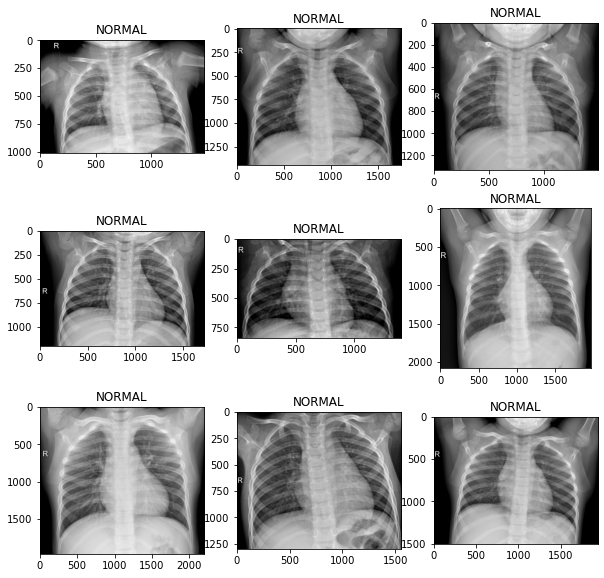

In [6]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NORMAL",NormalImages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

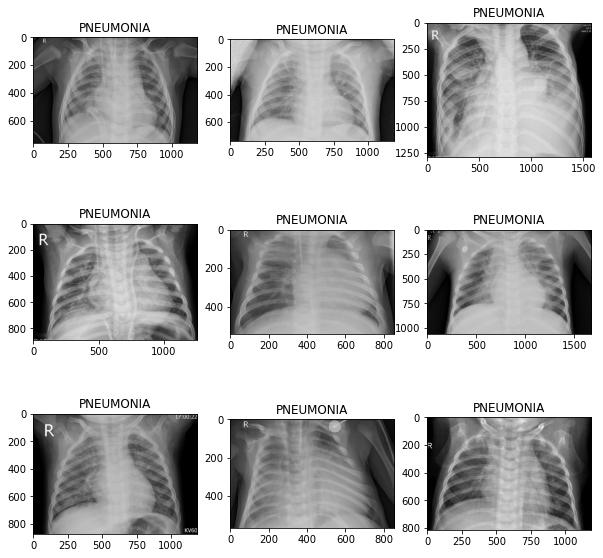

In [7]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/PNEUMONIA",PneumoniaImages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

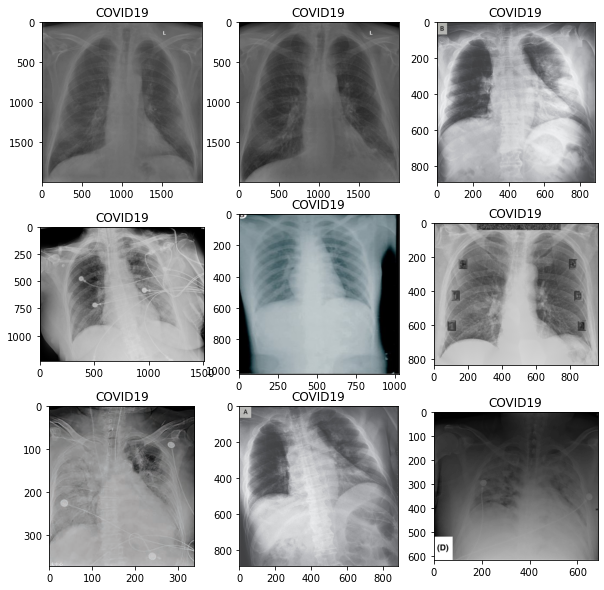

In [8]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19Images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

## Data sets 

In [9]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/kaggle/input/chest-xray-covid19-pneumonia/Data'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [11]:
training_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [12]:
testing_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

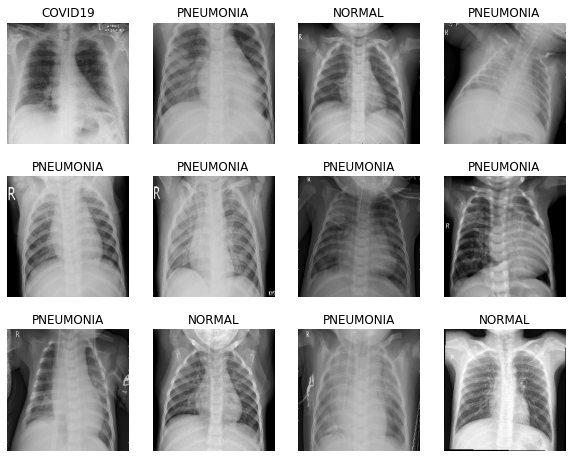

In [13]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

## Models

### Helpers

In [14]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [15]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [16]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [17]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [18]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [19]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [20]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 7.430434782608696, 1: 2.6998420221169037, 2: 1.0}

In [21]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape) 

82526208/82524592 [==============================] - 1s 0us/step
(None, 224, 224, 3)
268320768/268317848 [==============================] - 3s 0us/step
(None, 600, 600, 3)
553467904/553467096 [==============================] - 4s 0us/step
(None, 224, 224, 3)


## Pretrained densenet

In [22]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [23]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)   

Epoch 1/30
322/322 [==============================] - 278s 864ms/step - loss: 0.5967 - accuracy: 0.8523 - val_loss: 0.4385 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 2/30
322/322 [==============================] - 212s 659ms/step - loss: 0.4929 - accuracy: 0.9143 - val_loss: 0.4431 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 3/30
322/322 [==============================] - 205s 638ms/step - loss: 0.4740 - accuracy: 0.9285 - val_loss: 0.4506 - val_accuracy: 0.9247 - lr: 1.0000e-04
Epoch 4/30
322/322 [==============================] - 213s 661ms/step - loss: 0.4613 - accuracy: 0.9357 - val_loss: 0.4124 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 5/30
322/322 [==============================] - 213s 661ms/step - loss: 0.4563 - accuracy: 0.9357 - val_loss: 0.4294 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 6/30
322/322 [==============================] - 215s 669ms/step - loss: 0.4434 - accuracy: 0.9438 - val_loss: 0.4344 - val_accuracy: 0.9348 - lr: 1.0000e-04
Epoch 7/30
322/322 [==

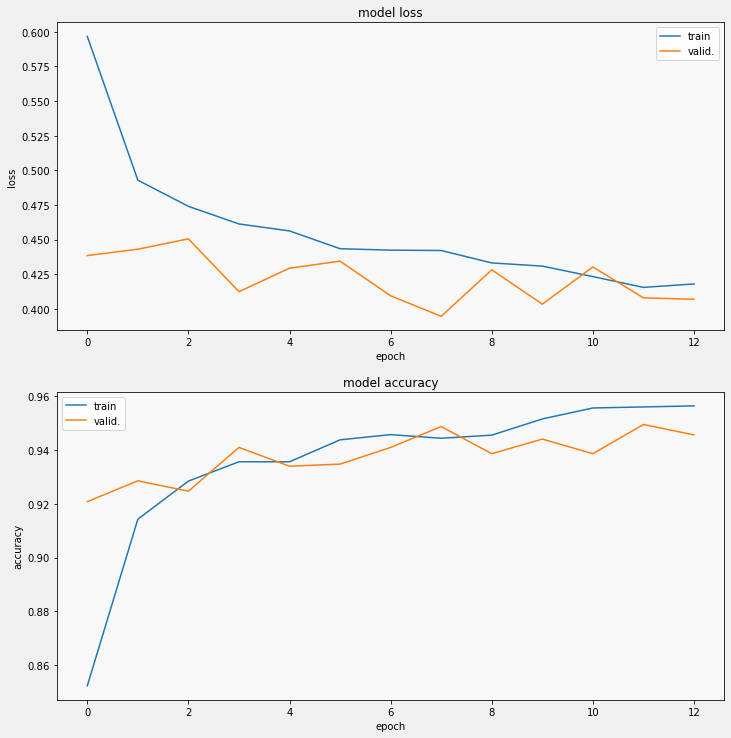

In [24]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

## Prediction Sample

In [25]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

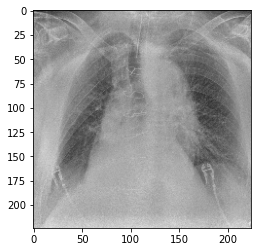

In [26]:
# test image
file_path =  '/test/COVID19/COVID19(464).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [27]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as COVID19


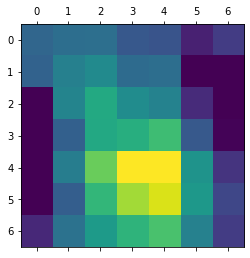

In [28]:
plt.matshow(heatmap)
plt.show()

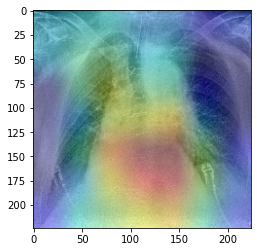

In [29]:
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

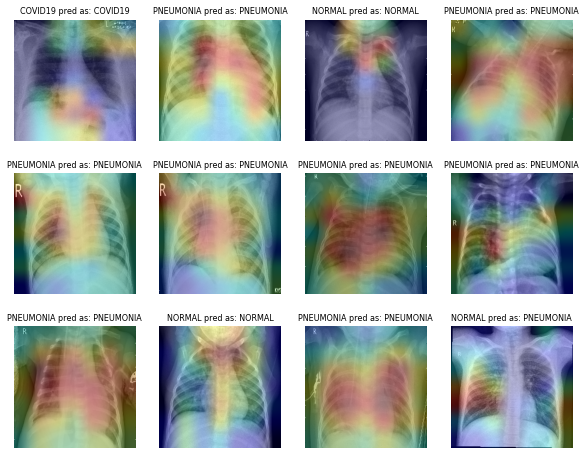

In [30]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)
    

In [31]:
model_densenet.save("model_densenet_30_09596.h5")

## Pretrained efnet

In [32]:
# https://github.com/keras-team/keras/issues/9064
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

258072576/258068648 [==============================] - 2s 0us/step
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_18[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
________________________

In [33]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)  

Epoch 1/30
322/322 [==============================] - 225s 698ms/step - loss: 0.8059 - accuracy: 0.6975 - val_loss: 0.7018 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 2/30
322/322 [==============================] - 218s 678ms/step - loss: 0.7025 - accuracy: 0.7644 - val_loss: 0.7007 - val_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 3/30
322/322 [==============================] - 216s 672ms/step - loss: 0.6737 - accuracy: 0.7895 - val_loss: 0.5759 - val_accuracy: 0.8509 - lr: 1.0000e-04
Epoch 4/30
322/322 [==============================] - 219s 680ms/step - loss: 0.6483 - accuracy: 0.8037 - val_loss: 0.6194 - val_accuracy: 0.8113 - lr: 1.0000e-04
Epoch 5/30
322/322 [==============================] - 217s 673ms/step - loss: 0.6277 - accuracy: 0.8151 - val_loss: 0.6558 - val_accuracy: 0.7446 - lr: 1.0000e-04
Epoch 6/30
322/322 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.8254
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
322/322 [

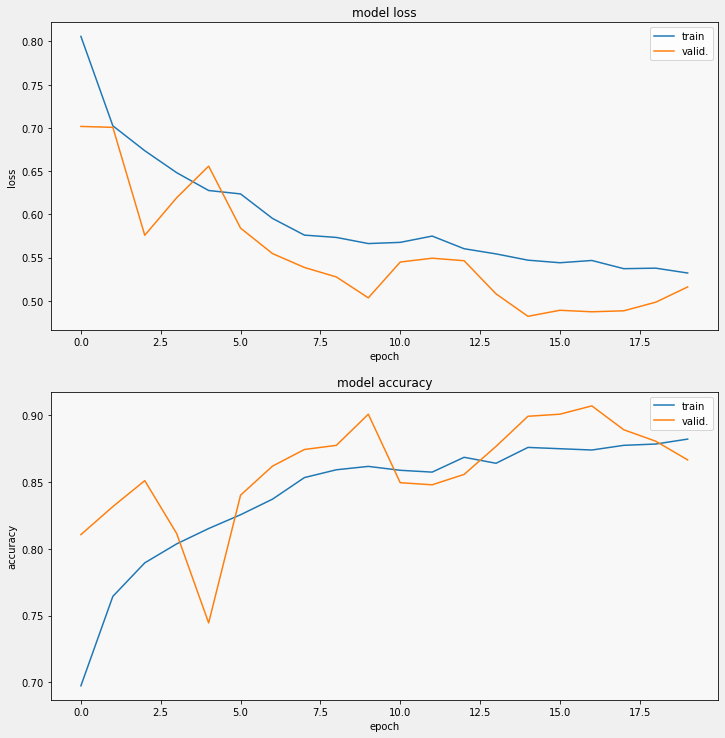

In [34]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

In [35]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

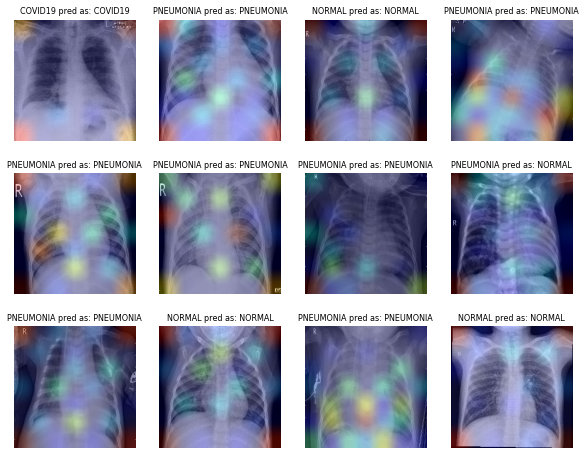

In [36]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_efnet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [37]:
model_efnet.save("model_efnet_30_09169.h5")

## Pretrained VGG

In [38]:
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x3 = pretrained_vgg.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x3)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
# model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])
model_vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [39]:
history_vgg = model_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)  

Epoch 1/30
322/322 [==============================] - 212s 658ms/step - loss: 0.7922 - accuracy: 0.7125 - val_loss: 0.5735 - val_accuracy: 0.8269 - lr: 1.0000e-04
Epoch 2/30
322/322 [==============================] - 207s 642ms/step - loss: 0.6249 - accuracy: 0.8208 - val_loss: 0.4949 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 3/30
322/322 [==============================] - 208s 646ms/step - loss: 0.5625 - accuracy: 0.8664 - val_loss: 0.4705 - val_accuracy: 0.9014 - lr: 1.0000e-04
Epoch 4/30
322/322 [==============================] - 210s 652ms/step - loss: 0.5286 - accuracy: 0.8939 - val_loss: 0.4454 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 5/30
322/322 [==============================] - 213s 663ms/step - loss: 0.5147 - accuracy: 0.9016 - val_loss: 0.4409 - val_accuracy: 0.9262 - lr: 1.0000e-04
Epoch 6/30
322/322 [==============================] - 214s 665ms/step - loss: 0.5050 - accuracy: 0.9073 - val_loss: 0.4358 - val_accuracy: 0.9239 - lr: 1.0000e-04
Epoch 7/30
322/322 [==

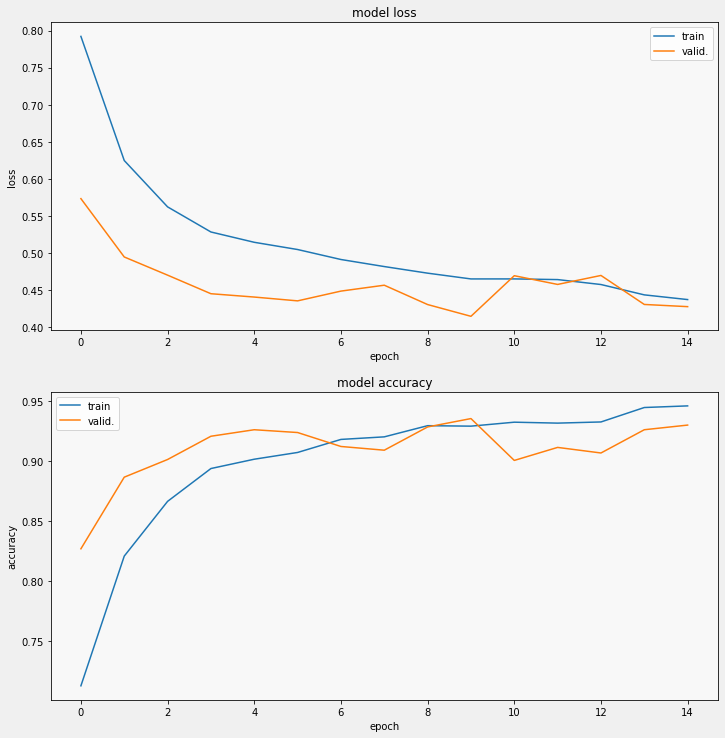

In [40]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [41]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

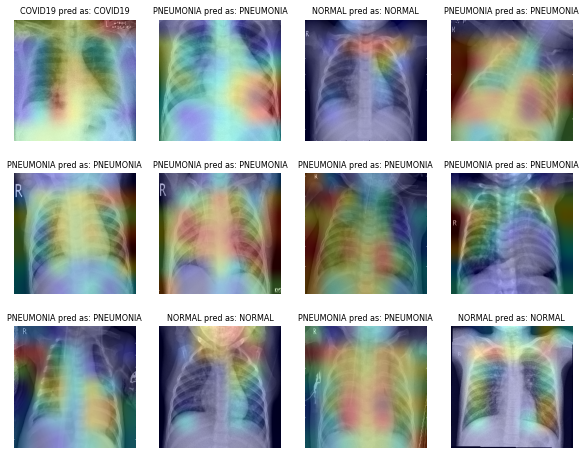

In [42]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_vgg, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [43]:
model_vgg.save("model_vgg_30_09286.h5")

## Ensemble (simply at the last layer)
The network tries to find a combination of final probs (not the best way, but very simple where we have only 30 learnable parameters)

In [44]:
# model_densenet
# model_efnet
# model_vgg

for layer in model_densenet.layers:
  layer.trainable = False

for layer in model_efnet.layers:
  layer.trainable = False

for layer in model_vgg.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet(visible)
x2 = model_efnet(visible)
x3 = model_vgg(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_densenet_efnet_vgg.summary()

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 3)            19428163    input[0][0]                      
__________________________________________________________________________________________________
model_27 (Model)                (None, 3)            65572499    input[0][0]                      
__________________________________________________________________________________________________
model_52 (Model)                (None, 3)            15313091    input[0][0]                      
___________________________________________________________________________________________

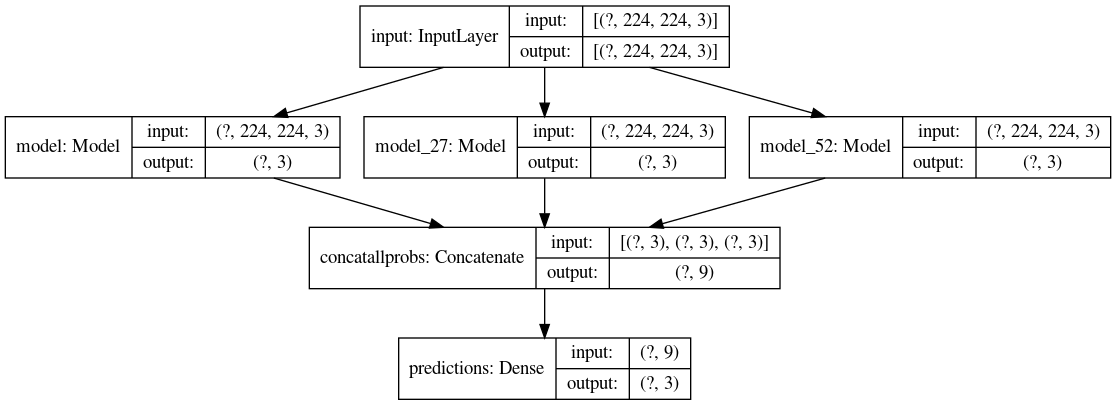

In [45]:
plot_model(model_densenet_efnet_vgg, show_shapes=True, to_file='model_densenet_efnet_vgg.png')

In [46]:
history = model_densenet_efnet_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=7)

Epoch 1/7
322/322 [==============================] - 230s 715ms/step - loss: 0.5731 - accuracy: 0.8785 - val_loss: 0.5214 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 2/7
322/322 [==============================] - 216s 672ms/step - loss: 0.5242 - accuracy: 0.8958 - val_loss: 0.4771 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 3/7
322/322 [==============================] - 217s 674ms/step - loss: 0.4807 - accuracy: 0.9098 - val_loss: 0.4396 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 4/7
322/322 [==============================] - 221s 686ms/step - loss: 0.4458 - accuracy: 0.9150 - val_loss: 0.4078 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 5/7
322/322 [==============================] - 210s 652ms/step - loss: 0.4124 - accuracy: 0.9238 - val_loss: 0.3803 - val_accuracy: 0.9348 - lr: 1.0000e-04
Epoch 6/7
322/322 [==============================] - 215s 668ms/step - loss: 0.3895 - accuracy: 0.9271 - val_loss: 0.3567 - val_accuracy: 0.9379 - lr: 1.0000e-04
Epoch 7/7
322/322 [=========

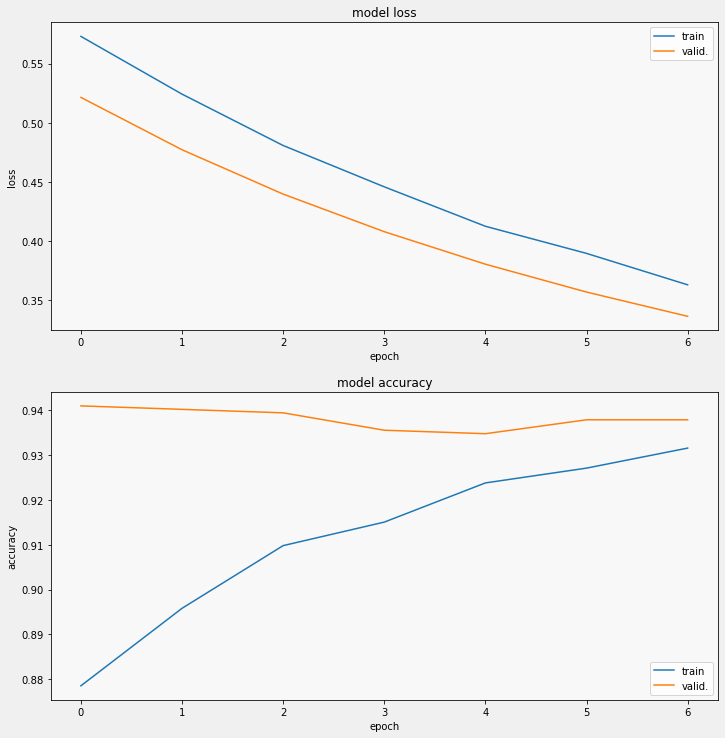

In [47]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [48]:
model_densenet_efnet_vgg.save("model_densenet_efnet_vgg_09581.h5")

## Ensemble: without the heads
Gives the network the chance to learn from the dense layers before the softmax

In [49]:
# model2= Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

model_densenet_nohead = Model(inputs=model_densenet.input, outputs=model_densenet.get_layer("dense_head").output)
model_efnet_nohead = Model(inputs=model_efnet.input, outputs=model_efnet.get_layer("dense_head").output)
model_vgg_nohead = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("dense_head_2").output)

for layer in model_densenet_nohead.layers:
  layer.trainable = False

for layer in model_efnet_nohead.layers:
  layer.trainable = False

for layer in model_vgg_nohead.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet_nohead(visible)
x2 = model_efnet_nohead(visible)
x3 = model_vgg_nohead(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg_nohead = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg_nohead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical_smooth_loss
model_densenet_efnet_vgg_nohead.summary()

Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_78 (Model)                (None, 64)           19427968    input[0][0]                      
__________________________________________________________________________________________________
model_79 (Model)                (None, 64)           65572304    input[0][0]                      
__________________________________________________________________________________________________
model_80 (Model)                (None, 64)           15312896    input[0][0]                      
___________________________________________________________________________________________

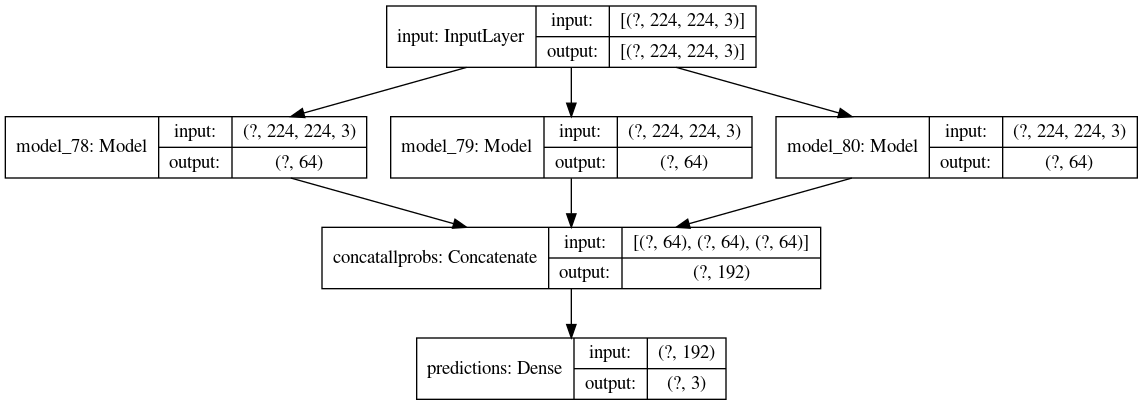

In [50]:
plot_model(model_densenet_efnet_vgg_nohead, show_shapes=True, to_file='model_densenet_efnet_vgg_nohead.png')

In [51]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=1, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [52]:
history_nohead = model_densenet_efnet_vgg_nohead.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=20)

Epoch 1/20
322/322 [==============================] - 224s 697ms/step - loss: 0.2689 - accuracy: 0.8915 - val_loss: 0.1812 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 2/20
322/322 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9685
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
322/322 [==============================] - 208s 647ms/step - loss: 0.0933 - accuracy: 0.9685 - val_loss: 0.1882 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 3/20
322/322 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9708
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
322/322 [==============================] - 214s 664ms/step - loss: 0.0888 - accuracy: 0.9708 - val_loss: 0.1851 - val_accuracy: 0.9371 - lr: 5.0000e-04
Epoch 4/20
322/322 [==============================] - 216s 672ms/step - loss: 0.0922 - accuracy: 0.9685 - val_loss: 0.1802 - val_accuracy: 0.9387 - lr: 2.5000e-04
Epoch 5/20
322/322 [======

In [53]:
model_densenet_efnet_vgg_nohead.save("model_densenet_efnet_vgg_nohead_09xxx.h5")